# External links and resources

Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

pois_processed: We processed points of interest JSON to be in a tabular form

# Introduction

Our solution focuses on forecasting traffic for the next day (at the same time) for the city of Porto. 

Regarding modeling, we used an XGBoost Classifier with weather features (current and forecast), historical intensity features, sensor position features (distance to sensor centroid).

We propose using this model for making decisions regarding traffic flow, by changing the amount of time that traffic lights are on - read more below :) 

# Development

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import holidays
from geopy.distance import geodesic
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import shap
from geopy.distance import geodesic
import folium
from folium.plugins import HeatMapWithTime

pd.set_option("display.max_colwidth", 500)
pt_holidays = holidays.CountryHoliday('Portugal')

# !pip install holidays
# !pip install openrouteservice
# !pip install geopy

## Load Data

This step of the script loads traffic, weather and air quality data.

We removed data in post-COVID periods (2019 and 2020) since our goal is to study how the city of Porto behaves regularly.

In [2]:
# Load preprocessed points of interest, data given by the WDL Organizers

df_pois = pd.read_csv('../data/pois_processed.csv')
data_entities = pd.read_csv('../data/data_entities.csv', sep=',', encoding='latin-1', error_bad_lines=False)

Using data about points of interest given by WDL team, we will calculate the number of points of interest in a 1.5km radius of each sensor, returning how many restaurants, stores, etc we have.

In [3]:
def return_amount_of_points_of_interest_per_sensor(df_pois, data_entities):

    def get_lat_lon_dist(row):
        latlon1 = tuple(row[['latitude1', 'longitude1']])
        latlon2 = tuple(row[['latitude2', 'longitude2']])

        return geodesic(latlon1, latlon2).kilometers

    df_pois[['latitude', 'longitude']] = df_pois['location'].str.split(' ', 1, expand=True)
    df_pois = df_pois.drop(1609) #NaN

    df_pois = df_pois[0:100] #FIXME, should run for all of them

    # Cross-join to get all combinations of lat/lon.
    dist = pd.merge(data_entities.assign(k=1), df_pois.assign(k=1), on='k', suffixes=('1', '2')) \
             .drop('k', axis=1)
    
    # TODO, less priority: See if we can make this function a bit faster 
    dist['dist_NOME_DA_ENTIDADE'] = dist.apply(get_lat_lon_dist, axis=1)
    
    # TODO: Add comments, what is this 1.5km etc
    dist_new = dist[['entity_id', 'id', 'category', 'dist_NOME_DA_ENTIDADE']].copy() 
    dist_new = dist_new.rename(columns = {'id': 'point of interest'}, inplace = False)
    dist_new['is_below_threshold'] = np.where(dist_new['dist_NOME_DA_ENTIDADE'] <= 1.5, 1, 0)
    sensor_categ=dist_new.groupby(['entity_id', 'category'])['is_below_threshold'].sum().reset_index()
    sensor_categ=sensor_categ.pivot_table(index="entity_id", columns="category", values="is_below_threshold")
    
    return sensor_categ

In [4]:
sensor_categ = return_amount_of_points_of_interest_per_sensor(df_pois, data_entities)

In [5]:
data_entities = data_entities.merge(sensor_categ, on=['entity_id'])

In [6]:
data_entities.head()

,entity_id,name,latitude,longitude,entity_type,street,start_date,end_date,Cafés,Centros Comerciais,Feiras e Mercados,Hotéis,Lojas,Postos de Abastecimento,Restaurantes
0,testsixsq,Rua dos Campeões Europeus,41.162590,-8.585198,TrafficFlowObserved,Rua dos Campeões Europeus,NaN,NaN,0,0,0,1,0,4,3
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,R. Fernandes Tomás - 24 de Agosto,41.148406,-8.599094,TrafficFlowObserved,Rua de Fernandes Tomás,NaN,NaN,1,1,1,7,10,8,26
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z3,R. Camões - N-S,41.154960,-8.610091,TrafficFlowObserved,Rua de Camões,NaN,NaN,1,1,1,8,10,7,22
3,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z4,Av. Boavista - Casa da Música - E-O,41.158701,-8.633546,TrafficFlowObserved,Avenida da Boavista,NaN,NaN,0,4,0,4,0,3,8
4,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z5,Via Panorâmica - Faixa BUS,41.151096,-8.633818,TrafficFlowObserved,Rua de Entre Campos,NaN,NaN,0,4,0,3,0,1,6


Load traffic, weather and air quality data, and resample to a period of an hour, to reduce dimensionality

In [7]:
def load_data(data_paths, date_col, value_cols, agg_operation = 'sum'):
    concat_data = []

    for file in data_paths:
        print("Reading file ", file)
        df = pd.read_csv('../data/' + file, encoding='latin-1')
        
        # print(df.head())

        df[date_col] = pd.to_datetime(df[date_col])
        
        df = df.drop_duplicates()

        df_resampled = df.set_index(date_col).groupby('entity_id')[value_cols].resample('H').agg(agg_operation).reset_index()
        concat_data.append(df_resampled)

    return pd.concat(concat_data)

TRAFFIC_DATA_PATH = [
    'traffic_flow_2018.csv',
    'traffic_flow_2019.csv'
]

WEATHER_DATA_PATH = [
    'weather_observed_2018.csv',
    'weather_observed_2019.csv'
]


AIR_QUALITY_PATH = [
    'air_quality_2018.csv',
    'air_quality_2019.csv'
]

date_col = 'dateobservedfrom'
value_cols = ['intensity']
files_name = TRAFFIC_DATA_PATH

traffic_data = load_data(files_name, date_col, value_cols, agg_operation = 'sum')
traffic_data.rename(columns={'dateobservedfrom': 'dateobserved'}, inplace=True)

WEATHER_COLS = [
    'barometricpressure',
    'dewpoint',
    'precipitation',
    'relativehumidity',
    'solarradiation',
    'temperature',
    'winddirection',
    'windspeed',
    'illuminance',
    'uvindexmax',
    'pressuretendency'
]

weather_data = load_data(data_paths = WEATHER_DATA_PATH, date_col = 'dateobserved', value_cols = WEATHER_COLS, agg_operation = 'mean')

AIR_QUALITY_COLS = [
    'no2',
    'o3',
    'ox',
    'co',
    'pm1',
    'pm25',
    'pm10'
]

air_quality_data = load_data(data_paths = AIR_QUALITY_PATH, date_col = 'dateobserved', value_cols = AIR_QUALITY_COLS, agg_operation = 'mean')

Reading file  traffic_flow_2018.csv
Reading file  traffic_flow_2019.csv
Reading file  weather_observed_2018.csv
Reading file  weather_observed_2019.csv
Reading file  air_quality_2018.csv
Reading file  air_quality_2019.csv


In [8]:
traffic_data.head(3)

,entity_id,dateobserved,intensity
0,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2017-12-31 00:00:00,224
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2017-12-31 01:00:00,186
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2017-12-31 02:00:00,177


In [9]:
air_quality_data.head(3)

,entity_id,dateobserved,no2,o3,ox,co,pm1,pm25,pm10
0,urn:ngsi-ld:AirQualityObserved:porto:environment:ubiwhere:5adf39366f555a4514e7ea54,2018-06-29 19:00:00,92.291666,15.991667,111.858334,400.441671,19.300000,48.100000,66.050000
1,urn:ngsi-ld:AirQualityObserved:porto:environment:ubiwhere:5adf39366f555a4514e7ea54,2018-06-29 20:00:00,65.308332,31.808334,99.925002,330.191661,18.525000,45.808333,64.525000
2,urn:ngsi-ld:AirQualityObserved:porto:environment:ubiwhere:5adf39366f555a4514e7ea54,2018-06-29 21:00:00,58.083333,36.225000,96.841668,351.274999,16.033333,40.391667,55.008333


In [11]:
weather_data.head(3)

,entity_id,dateobserved,barometricpressure,dewpoint,precipitation,relativehumidity,solarradiation,temperature,winddirection,windspeed,illuminance,uvindexmax,pressuretendency
0,urn:ngsi-ld:AirQualityObserved:porto:weather:ubiwhere:5ad613dd3da2520542bc871a,2018-06-29 18:00:00,1011.000000,NaN,0.0,0.833000,39.099998,19.700001,312.00,1.500000,NaN,NaN,NaN
1,urn:ngsi-ld:AirQualityObserved:porto:weather:ubiwhere:5ad613dd3da2520542bc871a,2018-06-29 19:00:00,1010.933339,NaN,0.0,0.856417,13.758334,19.533334,269.75,1.236111,NaN,NaN,NaN
2,urn:ngsi-ld:AirQualityObserved:porto:weather:ubiwhere:5ad613dd3da2520542bc871a,2018-06-29 20:00:00,1011.224991,NaN,0.0,0.887917,1.291667,18.875000,283.00,1.814815,NaN,NaN,NaN


To encode the latitude and longitude in a continuous way, we'll calculate the distance to the centroid as a feature

In [12]:
centroid = (data_entities['latitude'].astype(float).mean(), data_entities['longitude'].astype(float).mean())
data_entities['distance_to_centroid'] = data_entities.apply(lambda x: geodesic((x['latitude'], x['longitude']), centroid).meters, axis=1)

Let's start merging the data sources besides traffic into a single dataframe

In [15]:
df_resampled = traffic_data.merge(data_entities, on='entity_id')
df_resampled.latitude = df_resampled.latitude.astype(float)
df_resampled.longitude = df_resampled.longitude.astype(float)

df_resampled = df_resampled.sort_values(by=['entity_id', 'dateobserved'], ascending=True)

### Traffic Sensor Spatial and Temporal Relationship

The plot below shows the spatial and temporal relationship of traffic throughout the day. The median value of the intensity for each hour and for each sensor was calculated. 

TODO: Add conclusions here (Joana)

Perceber quais os mapas que fazem sentido

In [17]:
df_resampled['hour_today'] = df_resampled.dateobserved.dt.hour

df_day_list = []
for hour in df_resampled.hour_today.sort_values().unique():
    df_day_list.append(
        df_resampled.loc[df_resampled.hour_today == hour, ['latitude', 'longitude', 'intensity']].groupby(['latitude', 'longitude']).median().reset_index().values.tolist())

time_index = list(np.arange(0,24))

In [18]:
m = folium.Map(location=[41.16181,-8.62057], zoom_start=14)

HeatMapWithTime(df_day_list, index=time_index, radius=14, min_opacity=0.3, max_opacity=0.6, use_local_extrema=True).add_to(m)

m

## Sensor Location

There seem to be a total of 130 traffic flow sensors, 27 weather sensors, 18 noise sensors and 18 air quality sensors. 

The map below determines their distribution throughout the city of Porto.

- **Traffic Sensors**: In the area of "Foz" and "Campanhã", there seem to be less traffic sensors compared to the remaining major areas of Porto: Boavista, Antas, Baixa (Downtown) and Bonfim. 
- **Noise Sensors** - They're very close to the traffic sensors, so shouldn't really give any complementary information
- **Air Quality Sensors** - Three are in Viseu, not Porto. The remaining seem sparse and distant from traffic sensors, so it's hard to correlate a specific traffic sensor's intensity with the air quality in a different region (something that might also depend on the wind direction and intensity at that time). Their use for this problem could be in measuring the correlation between high traffic days and air quality a few moments later.
- **Weather Sensors** - There seems to be a relevant amount of coverage throughout the city 

TODO: We generated a new map where you can observe the different locations of the sensors...

In [19]:
def plot_sensors_location(data_entities):
    """
    Function for plotting sensors location in a map
    """

    m = folium.Map(location=[41.16181, -8.62057], zoom_start=14)

    for indice, row in data_entities.loc[data_entities["entity_type"]=="TrafficFlowObserved"].iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row['name'],
            icon=folium.Icon(color="red", icon='automobile', prefix='fa')
            ).add_to(m)

    for indice, row in data_entities.loc[data_entities["entity_type"]=="NoiseLevelObserved"].iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row['name'],
            icon=folium.Icon(color="green", icon='glyphicon glyphicon-bullhorn')
            ).add_to(m)

    for indice, row in data_entities.loc[data_entities["entity_type"]=="AirQualityObserved"].iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row['name'],
            icon=folium.Icon(color="blue", icon='leaf', prefix='fa')
            ).add_to(m)

    for indice, row in data_entities.loc[data_entities["entity_type"]=="WeatherObserved"].iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=row['name'],
            icon=folium.Icon(color="orange", icon='sun-o', prefix='fa')
            ).add_to(m)
    return m

m = plot_sensors_location(data_entities)

m

## Data Exploration

### Weather Data

Weather Data, which is very important for predicting traffic, has a lot of nulls for several values.
As there's no possible way to directly map a weather sensor location to a traffic sensor, we'll average the weather metrics per hour. 

In [20]:
weather_data.isna().mean()

entity_id             0.000000
dateobserved          0.000000
barometricpressure    0.702574
dewpoint              0.992544
precipitation         0.449303
relativehumidity      0.483395
solarradiation        0.746656
temperature           0.483395
winddirection         0.492127
windspeed             0.490850
illuminance           1.000000
uvindexmax            1.000000
pressuretendency      1.000000
dtype: float64

In [21]:
weather_data_agg = weather_data.groupby('dateobserved')[['barometricpressure', 'dewpoint', 'precipitation', 'relativehumidity', 'solarradiation', 'temperature', 'winddirection', 'windspeed', 'illuminance', 'uvindexmax', 'pressuretendency']].mean().reset_index()

In [22]:
df_resampled = df_resampled.merge(weather_data_agg, on=['dateobserved'])

### Traffic Data Sensor Regularity

In [ ]:
"""

TODO: Make a plot of two sensors with normal behavior and these sensors 
    with irregular behavior which we ended up removing from the analysis.

base_sensor_name = "urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:"
outlier_sensor_list = ["CT21Z1", "CT4Z9", "CT5Z8", "CT9Z2"]
outlier_sensor_list = [base_sensor_name+n for n in outlier_sensor_list]
outlier_sensor_list.append("testsixsq")

df_resampled = df_resampled[
    ~df_resampled['entity_id'].isin(outlier_sensor_list)
]
"""

In [ ]:
# tmp = df_resampled.groupby(['name', 'hour_today']).intensity.median().reset_index()

In [ ]:
# tmp[tmp.hour_today == 8].sort_values(by='intensity', ascending=False)

In [1]:
# TODO: Rever texto a explicar como é que, em média, o transito muda ao longo do dia na cidade do Porto
# TODO: Review code with the raw data before resampling to check if this makes sense 

The following image shows the regular behaviour of the intensity of the traffic during a day.

Starting the analysis at 00:00, we realise that the traffic intensity decreases during the night, which, for the city of Porto, makes sense. The intensity starts to increase around 04:00/05:00, which marks the time-points when persons start their working routine. It then increases until 10:00/11:00 and keeps an approximately stable behaviour until the end of the working hours, 18:00/19:00. The intensity starts to decrease until night.

![Traffic Data Sensor Regular Behaviour](../figures/ct1z6_intensity.png "Traffic Data Sensor Regular Behaviour")

# TODO: Make subplots with two regular sensors and two irregular sensors.

## Feature Extraction

Here's the data we have so far: a listing of car intensities and weather data for each hour

# TODO: Explain why we want to the day after and not the hour after!

The data may not be readily available, think about more things...

In [23]:
df_resampled.head(3)

,entity_id,dateobserved,intensity,name,latitude,longitude,entity_type,street,start_date,end_date,...,dewpoint,precipitation,relativehumidity,solarradiation,temperature,winddirection,windspeed,illuminance,uvindexmax,pressuretendency
0,testsixsq,2019-06-14 12:00:00,26,Rua dos Campeões Europeus,41.162590,-8.585198,TrafficFlowObserved,Rua dos Campeões Europeus,NaN,NaN,...,NaN,0.0,0.74893,707.915835,17.309441,251.010531,1.937994,NaN,NaN,NaN
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2019-06-14 12:00:00,0,R. Fernandes Tomás - 24 de Agosto,41.148406,-8.599094,TrafficFlowObserved,Rua de Fernandes Tomás,NaN,NaN,...,NaN,0.0,0.74893,707.915835,17.309441,251.010531,1.937994,NaN,NaN,NaN
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z3,2019-06-14 12:00:00,0,R. Camões - N-S,41.154960,-8.610091,TrafficFlowObserved,Rua de Camões,NaN,NaN,...,NaN,0.0,0.74893,707.915835,17.309441,251.010531,1.937994,NaN,NaN,NaN


In [24]:
# We had some weird cases of duplicates which are dropped here

df_resampled = df_resampled.drop_duplicates(['entity_id', 'dateobserved'])

In [25]:
def get_date_features(df_resampled, date_col, suffix):
    """
    Function for getting date features from a datetime column. 
    """
    df_resampled[f'day_{suffix}'] = df_resampled[date_col].dt.day
    df_resampled[f'hour_{suffix}'] = df_resampled[date_col].dt.hour
    df_resampled[f'month_{suffix}'] = df_resampled[date_col].dt.month
    df_resampled[f'dayofweek_{suffix}'] = df_resampled[date_col].dt.dayofweek
    # df_resampled[f'year_{suffix}'] = df_resampled[date_col].dt.year
    df_resampled[f'quarter_{suffix}'] = df_resampled[date_col].dt.quarter
    df_resampled[f'is_holiday_{suffix}'] = df_resampled[date_col].apply(lambda x: x in pt_holidays)
    # df_resampled[f'is_year_end_{suffix}'] = df_resampled[date_col].dt.is_year_end
    df_resampled[f'is_weekend_{suffix}'] = np.where(df_resampled[f'dayofweek_{suffix}'].isin([5, 6]), 1, 0)
                                                  
    return df_resampled

In [26]:
def create_target(df_resampled, target_col = 'intensity', date_offset = 24):
    """
    Function from creating lagged or future features for a specific date offset.
    For instance, this adds a new column with the intensity values 24 hours in the future, for each row, by default.    
    """
    
    df_resampled['dateobserved_tomorrow'] = df_resampled['dateobserved'] + pd.DateOffset(hours=date_offset)
    tmp = df_resampled[['entity_id', 'dateobserved', 'dateobserved_tomorrow', target_col]].merge(
        df_resampled[['entity_id', 'dateobserved', 'dateobserved_tomorrow', target_col]], 
        left_on = ['entity_id', 'dateobserved_tomorrow'], 
        right_on=['entity_id', 'dateobserved'], 
        how='left'
    )

    tmp = tmp[['entity_id', 'dateobserved_x', f'{target_col}_y']]
    tmp.columns = ['entity_id', 'dateobserved', f'target_{target_col}_{str(date_offset)}h']

    df_resampled = df_resampled.merge(tmp, on=['entity_id', 'dateobserved'])
    
    return df_resampled

Let's create our target, which we defined as a traffic prediction for the following day, at the same time.
We will explain our decisions for this offset in the conclusion, as it serves using our solution in practice.

In [27]:
df_resampled = create_target(df_resampled, target_col = 'intensity', date_offset=24)

In [28]:
df_resampled = get_date_features(df_resampled, 'dateobserved_tomorrow', 'tomorrow')
df_resampled = get_date_features(df_resampled, 'dateobserved', 'today')

In [29]:
df_resampled.head(3)

,entity_id,dateobserved,intensity,name,latitude,longitude,entity_type,street,start_date,end_date,...,dayofweek_tomorrow,quarter_tomorrow,is_holiday_tomorrow,is_weekend_tomorrow,day_today,month_today,dayofweek_today,quarter_today,is_holiday_today,is_weekend_today
0,testsixsq,2019-06-14 12:00:00,26,Rua dos Campeões Europeus,41.162590,-8.585198,TrafficFlowObserved,Rua dos Campeões Europeus,NaN,NaN,...,5,2,False,1,14,6,4,2,False,0
1,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2019-06-14 12:00:00,0,R. Fernandes Tomás - 24 de Agosto,41.148406,-8.599094,TrafficFlowObserved,Rua de Fernandes Tomás,NaN,NaN,...,5,2,False,1,14,6,4,2,False,0
2,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z3,2019-06-14 12:00:00,0,R. Camões - N-S,41.154960,-8.610091,TrafficFlowObserved,Rua de Camões,NaN,NaN,...,5,2,False,1,14,6,4,2,False,0


It's also very important we create lagged features: what occured in the past, in the same day

In [30]:
def rolling_fts_intensity(df_resampled, group_cols, window, agg_cols = ['mean', 'max', 'min', 'std']):
    """
    Function for calculating aggregated rolling features
    """
    rolling_fts = df_resampled.groupby(group_cols)['intensity'].shift(1).rolling(window).agg(['mean', 'max', 'min', 'std'])

    group_cols_str = '_'.join(group_cols)
    rolling_fts.columns = [
        f'intensity_{group_cols_str}_{str(window)}_mean',
        f'intensity_{group_cols_str}_{str(window)}_max',
        f'intensity_{group_cols_str}_{str(window)}_min',
        f'intensity_{group_cols_str}_{str(window)}_std',
    ]
    df_resampled = pd.concat([df_resampled, rolling_fts], axis=1)
    return df_resampled

# TODO havendo tempo: Transformar este 24, 48, ... em lags de dias/horas.
# De momento não está 100% correto porque alguns sensores tem falta de dados.

for day in [24, 24*2, 24*3, 24*4, 24*5, 24*6]:
    df_resampled = rolling_fts_intensity(df_resampled, ['entity_id'], day)

df_resampled = rolling_fts_intensity(df_resampled, ['entity_id', 'dayofweek_today'], 24)

# Get target intensity 24 hours ago
for date_offset in [-24, -24*2, -24*3, -24*4, -24*5, -24*6, -24*7]:
    df_resampled = create_target(df_resampled, target_col = 'intensity', date_offset=date_offset)

Here's an example of what the target looks like.
For this entity, on 2018-10-07 00:00, we observe an intensity of 104. The target, the number of cars on the following day at 00:00, is 95, which appears on the following row.

In [31]:
df_resampled[
    (
        (df_resampled.dateobserved == pd.to_datetime('2018-10-07 00:00:00')) | (df_resampled.dateobserved == pd.to_datetime('2018-10-08 00:00:00'))
    ) & (df_resampled.entity_id == 'urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2')
][['entity_id', 'dateobserved', 'dateobserved_tomorrow', 'intensity', 'target_intensity_-24h', 'target_intensity_24h']]

,entity_id,dateobserved,dateobserved_tomorrow,intensity,target_intensity_-24h,target_intensity_24h
250189,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2018-10-07,2018-09-30,104,76.0,95.0
252685,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT10Z2,2018-10-08,2018-10-01,95,104.0,57.0


Let's assume we had tomorrow's weather - since we don't have historical forecasts we'll just use tomorrow's weather as if we had a forecast tool available

In [32]:
df_resampled = create_target(df_resampled, target_col = 'precipitation', date_offset=24)
df_resampled = create_target(df_resampled, target_col = 'temperature', date_offset=24)
df_resampled = create_target(df_resampled, target_col = 'relativehumidity', date_offset=24)

df_resampled = create_target(df_resampled, target_col = 'precipitation', date_offset=-24)
df_resampled = create_target(df_resampled, target_col = 'temperature', date_offset=-24)
df_resampled = create_target(df_resampled, target_col = 'relativehumidity', date_offset=-24)

In [33]:
COLS_TO_REMOVE = [
    'entity_id',
    'dateobserved',
    'name',
    'latitude',
    'longitude',
    'entity_type',
    'street',
    'start_date',
    'end_date',
    'target_intensity_24h',
    'dateobserved_tomorrow',
    'illuminance',
    'uvindexmax',
    'pressuretendency',
    'solarradiation',
    'dewpoint',
    'barometricpressure',
    'winddirection',
    'windspeed',
    'year_tomorrow',
    'year_today'
]

COLS_TO_KEEP = [x for x in df_resampled.columns if x not in COLS_TO_REMOVE]

These will be the features that we will input into our model

In [34]:
COLS_TO_KEEP

['intensity',
 'Cafés',
 'Centros Comerciais',
 'Feiras e Mercados',
 'Hotéis',
 'Lojas',
 'Postos de Abastecimento',
 'Restaurantes',
 'distance_to_centroid',
 'hour_today',
 'precipitation',
 'relativehumidity',
 'temperature',
 'day_tomorrow',
 'hour_tomorrow',
 'month_tomorrow',
 'dayofweek_tomorrow',
 'quarter_tomorrow',
 'is_holiday_tomorrow',
 'is_weekend_tomorrow',
 'day_today',
 'month_today',
 'dayofweek_today',
 'quarter_today',
 'is_holiday_today',
 'is_weekend_today',
 'intensity_entity_id_24_mean',
 'intensity_entity_id_24_max',
 'intensity_entity_id_24_min',
 'intensity_entity_id_24_std',
 'intensity_entity_id_48_mean',
 'intensity_entity_id_48_max',
 'intensity_entity_id_48_min',
 'intensity_entity_id_48_std',
 'intensity_entity_id_72_mean',
 'intensity_entity_id_72_max',
 'intensity_entity_id_72_min',
 'intensity_entity_id_72_std',
 'intensity_entity_id_96_mean',
 'intensity_entity_id_96_max',
 'intensity_entity_id_96_min',
 'intensity_entity_id_96_std',
 'intensity_en

In [35]:
# Train model

X_train = df_resampled[0:int(0.8*len(df_resampled))]
X_train = X_train[~X_train.target_intensity_24h.isna()]

X_test = df_resampled[int(0.8*len(df_resampled)):]
X_test = X_test[~X_test.target_intensity_24h.isna()]

In [36]:
y_train = X_train['target_intensity_24h']

In [37]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
y_pred = xgb.predict(X_test[COLS_TO_KEEP].fillna(9999).astype(float))
X_test['pred_score'] = y_pred

Below we get our model predictions compared to a dummy model, which always predicts that today's intensity will be the same as th etarget.

Our model is a lot better than the baseline model, in the specified metrics. 

In [39]:
# Predicting that today's intensity will be the same as the target for baseline

dummy_regressor = X_test['intensity']

print("MAE", mean_absolute_error(dummy_regressor, X_test['target_intensity_24h']))
print("MSE", mean_squared_error(dummy_regressor, X_test['target_intensity_24h']))
print("Spearman Rank", spearmanr(dummy_regressor, X_test['target_intensity_24h']))
print("Pearson Rank", pearsonr(dummy_regressor, X_test['target_intensity_24h']))

MAE 114.72145553490333
MSE 243463.1620480196
Spearman Rank SpearmanrResult(correlation=0.9032227912634424, pvalue=0.0)
Pearson Rank (0.652031695107003, 0.0)


In [40]:
# Model predictions

print("MAE", mean_absolute_error(y_pred, X_test['target_intensity_24h']))
print("MSE", mean_squared_error(y_pred, X_test['target_intensity_24h']))
print("Spearman Rank", spearmanr(y_pred, X_test['target_intensity_24h']))
print("Pearson Rank", pearsonr(y_pred, X_test['target_intensity_24h']))

MAE 94.06972810463796
MSE 159058.90832726125
Spearman Rank SpearmanrResult(correlation=0.9240249692210754, pvalue=0.0)
Pearson Rank (0.741088839199921, 0.0)


## Results Analysis

In [ ]:
X_test[X_test['intensity'] > 6000].head()[['dateobserved', 'entity_id', 'intensity', 'dayofweek_today', 'pred_score', 'target_intensity_24h', 'is_weekend_today', 'is_weekend_tomorrow']]

Text(0.5, 0, 'Ground truth')

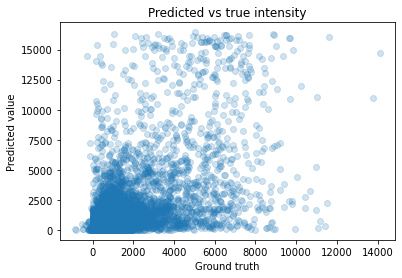

In [41]:
plt.title("Predicted vs true intensity")
plt.scatter(y_pred, X_test['target_intensity_24h'], alpha=0.2)
plt.ylabel('Predicted value')
plt.xlabel('Ground truth')

SHAP Plot below shows us the model focuses mostly on lagged features, month features (correlated with sazonality) and some weather features.

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test[COLS_TO_KEEP].fillna(9999).astype(float))

In [ ]:
shap.plots.beeswarm(shap_values, max_display=15)

In [3]:
# TODO: Plot das previsões no mapa
# Tomé e Joana tratam

An example of the model predictions shape and the ground truth

In [ ]:
tmp = X_test[X_test.entity_id == 'urn:ngsi-ld:TrafficFlowObserved:porto:traffic:CMP:CT7Z3']

In [ ]:
tmp = tmp[
    (tmp.dateobserved < '2018-08-10')# & (tmp.dateobserved > '2018-05-18')
]
tmp

In [ ]:
plt.plot(tmp['dateobserved'][900:1000], tmp['pred_score'][900:1000], label='pred')
plt.plot(tmp['dateobserved'][900:1000], tmp['target_intensity_24h'][900:1000], label='true')
plt.legend()

# TODO: Check if we can make this plot prettier and interactive 

# Conclusions

## How can this traffic-flow forecasting model help us achieve a much more sustainable Porto city?
Following the contextualisation of the WDL team in the challenge document, we start by showing some of the correlations between traffic intensity and the presence of air pollutants:

### TODO: Colocar em forma de Tabela!

We also find it useful to give you some insights about these chemicals to give you intuition on why it is important to keep their concentration in the atmosphere as lower as possible.
 1. NO2: it is one of a group of highly reactive gases known as oxides of nitrogen or nitrogen oxides (NOx). This gas primarily gets in the air from the burning of fuel. For instance, it forms from emissions from cars, trucks and buses, power plants, and off-road equipment. The presence of high concentrations of NO2 in the atmosphere may contribute to several respiratory complications in human beings. Hence, if one lives in a city with high concentrations of NO2, one may be more likely to develop respiratory diseases (particularly, asthma). On the other hand, this presence of NO2 in the atmosphere has also several negative effects on the environment (e.g., NO2 interacts with water, oxygen and other chemicals in the atmosphere to form acid rain, which impacts sensitive ecosystems). Please refer to: [https://www.epa.gov/no2-pollution/basic-information-about-no2#:~:text=Nitrogen%20Dioxide%20(NO2)%20is,from%20the%20burning%20of%20fuel.](https://www.epa.gov/no2-pollution/basic-information-about-no2#:~:text=Nitrogen%20Dioxide%20(NO2)%20is,from%20the%20burning%20of%20fuel.)).
 2. O3: it is a gas composed of three atoms of oxygen and is commonly known as ozone. At a stratospheric level, this gas occurs naturally and is extremely useful in the sense that it forms a protective layer that shields us from the sun's harmful ultraviolet rays. However, at a tropospheric level (i.e., ground level), ozone is created by chemical reactions between oxides of nitrogen and volatile organic compounds (e.g., when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight). Similarly to NO2, ozone is extremely harmful to the respiratory system and may contribute to several other environmental complications (i.e., elevated exposures to ozone can affect sensitive vegetation and ecosystems, including forests, parks, wildlife refuges and wilderness areas). Please refer to: [https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics](https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics)).
 3. Ox: TODO (Tiago)
 4. CO: carbon monoxide is also present in the exhaust gases of internal combustion engines and furnaces as a result of the incomplete conversion of carbon or carbon-containing fuels to carbon dioxide. This compound is dangerous to human health since its absorption by red blood cells in preference to oxygen will create a negative impact on the transport of oxygen from the lungs to the tissues, in which it is required. Please refer to: [https://www.britannica.com/science/carbon-monoxide](https://www.britannica.com/science/carbon-monoxide)).
 5. PM1, PM2.5 and PM10: https://www.sciencedirect.com/science/article/abs/pii/S1352231007003299

We now show you example plots to give you the intuition of how traffic intensity contributes to the increase of the concentration of air pollutants in the atmosphere. 

As we explained above, the burning of fossil fuels generates chemical compounds that act as precursors of these pollutants.

Hence, we can see that there is a positive correlation between traffic intensity and the concentration/level of air pollutants in the atmosphere.

# TODO: Inserir gráfico do CO.

Traffic Intensity

![Traffic Intensity](../figures/ct1z6_intensity.png "Traffic Intensity")

NO2 Concentration

![NO2 Concentration](../figures/ct1z6_no2.png "NO2 Concentration")

O3

![O3 Concentration](../figures/ct1z6_o3.png "NO2 Concentration")

Ox

![Ox Concentration](../figures/ct1z6_ox.png "Ox Concentration")

PM1

![PM1](../figures/ct1z6_pm1.png "PM1")

PM2.5

![PM2.5](../figures/ct1z6_pm25.png "PM25")

PM10

![PM10](../figures/ct1z6_pm10.png "PM10")

# Scalability and Impact

The impact of tourism and the economic growth that has taken place in Porto translates into an increase in the number of cars in circulation (source: https://www.dinheirovivo.pt/empresas/porto-tem-mais-carros-por-habitante-do-que-lisboa-12798231.html). Per year, there has been a 6.6% increase in the number of cars in circulation in the Greater Porto region, and this increase does not seem to be slowing down. 

Let's take the year 2018 as an example. In 2018, the annual average daily traffic was equal to 28,014 vehicles per day, which at the end of the year results in a circulation of approximately 10225 vehicles. Knowing that a typical passenger car emits about 4600 kg of CO2 per year (https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle), there is an increase in CO2 emissions of 47M kg per year!

Considering that at an average speed of 30 mph and 40 mph, CO2 consumption is approximately 350 g/mi and 310 g/mi, respectively (source: image deliverable), and that on average, the distance traveled by a Portuguese citizen is 9000 km (source: https://www.publico.pt/2018/01/23/sociedade/noticia/quem-e-o-condutor-portugues-conduz-nove-mil-quilometros-por-ano-tem-carro-com-uma-decada-e-usao-diariamente-1800028), for the same distance traveled, you save ((350-310) * (9000*0,621371192))=223.69 kg CO2 if you increase the speed from 30 mph to 40 mph. 

Thus, the construction of intelligent traffic lights that would turn on and off according to the areas and times of heaviest traffic, would allow the decongestion of traffic in these regions and a greater flow of cars, which would therefore increase their speed and contribute to the reduction of CO2 emissions. This initiative would contribute to making the city of Porto a more sustainable and environmentally friendly city through traffic changes (https://www.porto.pt/pt/noticia/camara-estuda-medidas-para-um-porto-sustentavel-e-mais-amigo-do-ambiente, https://www.porto.pt/pt/noticia/camara-vai-consumir-energia-100-renovavel-e-evitar-a-emissao-de-165-toneladas-de-co2-por-ano, https://www.publico.pt/2020/09/28/local/noticia/novo-pdm-promete-porto-denso-verde-2030-1932911). 

# TODO: Check source of this image (below), perceber alinhamento estratégico e político da Cidade do Porto quanto à sustentabilidade e ao CO2.

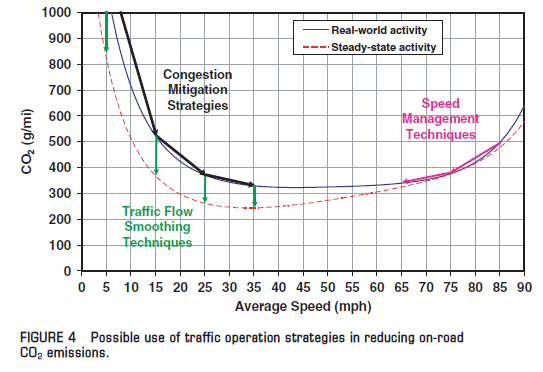

# Ideias:

- Otimização de rotas - Google Does It
- Mais vigilância nas zonas com mais trânsito (maior propensão a acidentes) +  Deteção de anomalias com forecasting. 
- Semáforos inteligentes: começas com um modelo de forecasting para perceber quais as zonas a uma certa hora que tèm maior transito, nessas vais ligar de forma diferente os semáforos. Fazes aquisiçao continua de dados e retreinas no futuro um modelo que tem uma feature que é (lat, long, semaforo_ativo). Ao mudar ovalor dessa feature, consegues perceber como isso influencia o transito na cidade do Porto. Podes generalizar isto para N temas: sinais de stop, ... 
- Saúde das pessoas (TODO: pesquisar efeito dos outros componentes do air quality), cidade sustentável
- Saúde: rever https://www.universityofcalifornia.edu/news/how-traffic-jams-affect-heart-health


https://time.com/5502192/smart-traffic-lights-ai/
https://en.wikipedia.org/wiki/Smart_traffic_light
https://www.zdnet.com/article/ai-based-traffic-management-gets-green-light/ 

- Ajudar o planeamento urbano: em sítios com alta densidade de trânsito, queres retirar o trânsito ou garantir a segurança dos peões 

# Future Work

Based on our proposal, it would be interesting if we could have access to:
 - data regarding the position of traffic lights;
 - the average speed of cars in that localisation;
 - CO2 levels.

This way, we could analyse the impact of our solution, as well as extract the correlations between the average speed of cars and the air quality.

# TODO: Explain this (above)!